In [11]:
using PyPlot
using Statistics, Distributions, Random
using FFTW
using Interpolations

In [12]:
"""
f:  frequency
h0: white noise amplitude
hg: servo-bump noise amplitudes
σg: servo-bump noise widths 
fg: servo-bump noise centers
"""
function Sϕ(f, h0, hg, σg, fg)
    res = 2.0 * h0 * ones(length(f));
    
    if length(hg) > 0
        for i ∈ [1:length(hg);]
            res = res .+ 2*hg[i] .* exp.(-(f .- fg[i]).^2 ./ (2 * σg[i]^2));
        end;
    end;
        
    return res ./ (f .^ 2)
end;



function ϕ(t, h0, hg, σg, fg)
    M = length(t);
    T = t[end];
    
    F = 10.0;
    Δf = F/1e4;
    f = [Δf:Δf:F;];
    N = length(f);
    ϕf = rand(Uniform(0.0, 2.0*π), N);
    amplitudes = 2.0 .* sqrt.(Δf * Sϕ(f, h0, hg, σg, fg));

    res = vec(sum(amplitudes .* cos.(2*π * f .* t' .+ ϕf),dims=1));
    return res
end;

__Noise spectral densities__

In [13]:
#Saffman params
h0 = 13.0 * 1e-6;   #MHz^2/MHz
hg1 = 25.0 * 1e-6;  #MHz^2/MHz
hg2 = 2.0e3 * 1e-6; #MHz^2/MHz
fg1 = 130.0 * 1e-3; #MHz
fg2 = 234.0 * 1e-3; #MHz
σg1 = 18.0 * 1e-3;  #MHz
σg2 = 1.5 * 1e-3;   #MHz

hg = [hg1, hg2];
σg = [σg1, σg2];
fg = [fg1, fg2];

T = 4.0;
M = floor(Int, 1e3);
dt = T/M;
tspan = [0.0:dt:T;]

F = 0.3;
Δf = F/1e3;
f = [0.01:Δf:F;];

figure(figsize=(10,4))
subplot(121)
plot(f, log.(1.26, Sϕ(f, h0, hg, σg, fg) .* (f .^2)));
xlim(0.0,0.3)
xlabel("Frequency,f (MHz)")
ylabel("\$ S_{δν} (dB) \$")

subplot(122)
plot(f, -40 .+ log.(1.26, Sϕ(f, h0, hg, σg, fg)));
xlim(0.0,0.3)
xlabel("Frequency,f (MHz)")
ylabel("\$ S_ϕ (dB) \$")

tight_layout()

# savefig("data/spectral_densities.pdf", dpi=300)

In [14]:
laser_phase_params = [h0, hg, σg, fg];
ampl = ϕ_amplitudes_test(f, laser_phase_params);

ϕ_abc(t) = ϕ_test(tspan, f, ampl)(t)

ϕ_abc (generic function with 1 method)

__Phase noise trajectories__

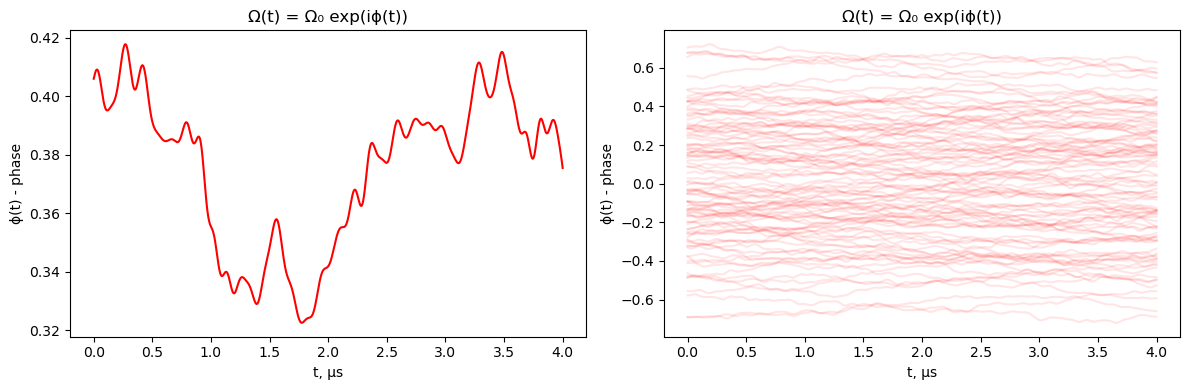

In [20]:
figure(figsize=(12, 4))
subplot(121)
plot(tspan, ϕ(tspan, h0, hg, σg, fg), color="red");
xlabel("t, μs")
ylabel("ϕ(t) - phase")
title("Ω(t) = Ω₀ exp(iϕ(t))")


subplot(122)
for i ∈ [1:100;]
    plot(tspan, ϕ(tspan, h0, hg, σg, fg), alpha=0.1, color="red");
end;
xlabel("t, μs")
ylabel("ϕ(t) - phase")
title("Ω(t) = Ω₀ exp(iϕ(t))")

tight_layout()
gcf()

#### Low frequency(~100kHz) servo-bump noise trajectories

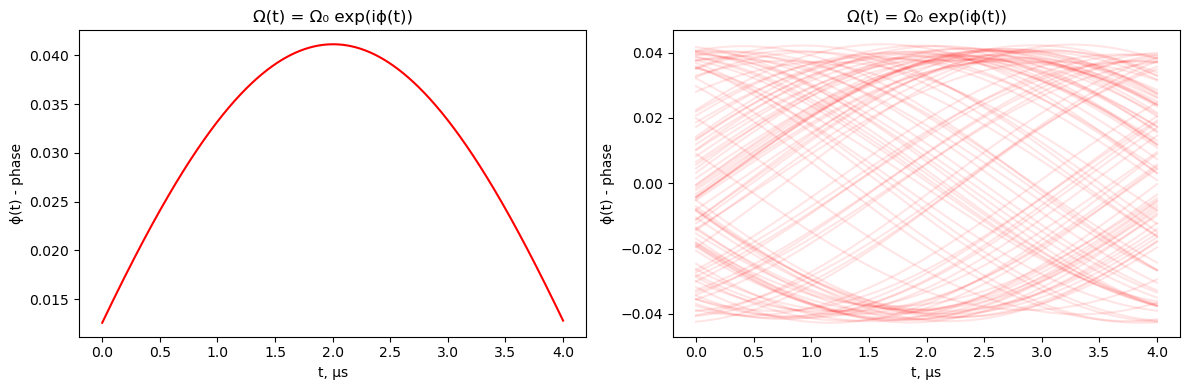

In [22]:
figure(figsize=(12, 4))
subplot(121)
plot(tspan, ϕ(tspan, 0.0, hg2, σg2 * (0.1/fg2)^2, 0.1), color="red");
xlabel("t, μs")
ylabel("ϕ(t) - phase")
title("Ω(t) = Ω₀ exp(iϕ(t))")


subplot(122)
for i ∈ [1:100;]
    plot(tspan, ϕ(tspan, 0.0, hg2, σg2 * (0.1/fg2)^2, 0.1), alpha=0.1, color="red");
end;
xlabel("t, μs")
ylabel("ϕ(t) - phase")
title("Ω(t) = Ω₀ exp(iϕ(t))")

tight_layout()
gcf()

__Noise interpolation__

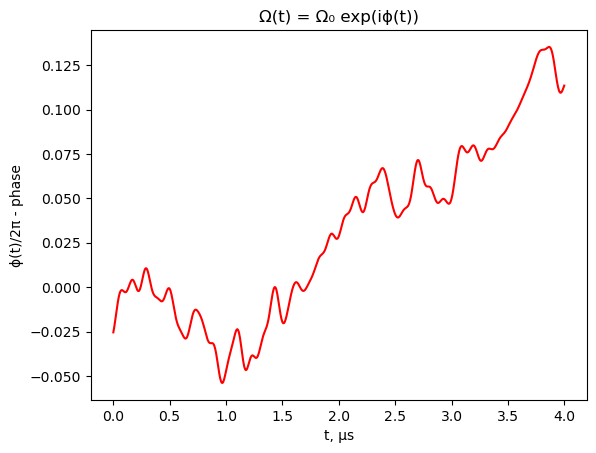

In [26]:
noise = ϕ(tspan, 1.0e-3, [], [], []);

figure()
plot(tspan, noise / (2*π), color="red");
xlabel("t, μs")
ylabel("ϕ(t)/2π - phase")
title("Ω(t) = Ω₀ exp(iϕ(t))")

nodes = (tspan, );
noise_intp = interpolate(nodes, noise, Gridded(Linear()));
gcf()

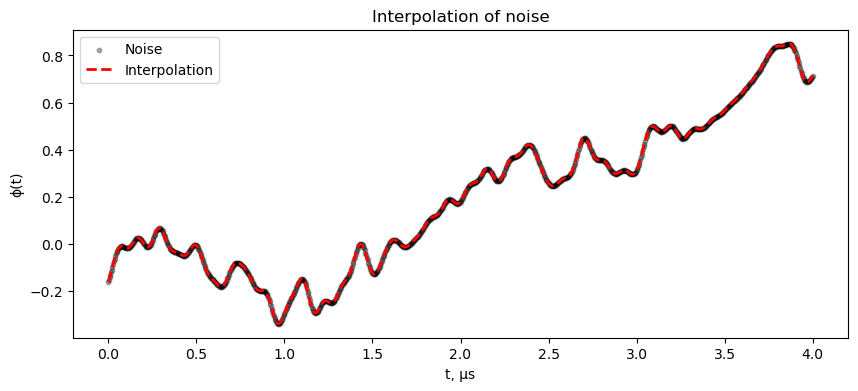

In [31]:
figure(figsize=(10,4))
scatter(tspan, noise, s=10, color="black", label="Noise", alpha=0.3)
plot(tspan, noise_intp(tspan), color="red", linestyle="--", label="Interpolation", linewidth=2)
title("Interpolation of noise")
xlabel("t, μs")
ylabel("ϕ(t)")
legend()
gcf()